## 1 hot Encoding

In [1]:
import numpy as np

# Define the RNA alphabet
rna_alphabet = ['A', 'C', 'G', 'T']


def rna_to_one_hot(rna_sequence):
    """
    Converts an RNA sequence to a 1-hot encoded matrix.

    Parameters:
        rna_sequence (str): RNA sequence to be converted.

    Returns:
        numpy.ndarray: 1-hot encoded matrix of the RNA sequence.
    """
    # Initialize an empty matrix with the correct dimensions
    one_hot = np.zeros((len(rna_sequence), len(rna_alphabet)), dtype=int)

    # Iterate through each nucleotide in the RNA sequence
    for i, nucleotide in enumerate(rna_sequence):
        if nucleotide == "N":
            continue
        # Find the index of the nucleotide in the RNA alphabet
        j = rna_alphabet.index(nucleotide)
        # Set the corresponding element in the 1-hot matrix to 1
        one_hot[i, j] = 1

    return one_hot


## Read file

In [2]:
# change fasta file into a list of sequences
# fasta reader
def read_fasta(file):
    with open(file, 'r') as f:
        lines = f.readlines()
    return lines

# fasta parser


def parse_fasta(lines):
    seq_list = []
    seq_name = [int(line[-2]) for line in lines if line.startswith('>')]
    seq = ''
    for line, index in zip(lines, range(len(lines))):
        if index == len(lines) - 1:
            seq += line.strip()
            seq_list.append(seq)
        if line.startswith('>'):
            seq_list.append(seq)
            seq = ''
            continue
        else:
            seq += line.strip()
    for i in seq_list:
        if i == '':
            seq_list.remove(i)
    return seq_list, seq_name

## Sim 1

In [3]:
x_train, y_train = parse_fasta(read_fasta('./sim1/train.fasta'))
x_train = [rna_to_one_hot(i) for i in x_train]
x_train = np.array(x_train)
y_train = np.array(y_train)

x_validation, y_validation = parse_fasta(read_fasta('./sim1/validation.fasta'))
x_validation = [rna_to_one_hot(i) for i in x_validation]
x_validation = np.array(x_validation)
y_validation = np.array(y_validation)

x_test, y_test = parse_fasta(read_fasta('./sim1/test.fasta'))
x_test = [rna_to_one_hot(i) for i in x_test]
x_test = np.array(x_test)
y_test = np.array(y_test)

In [4]:
from tensorflow import keras as keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.callbacks import EarlyStopping, History

# Define the model
sequence_length = x_train.shape[1]
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=10, activation='relu',
          input_shape=(sequence_length, 4)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=64, activation='LeakyReLU'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, verbose=1,  
 validation_data=(x_validation, y_validation),batch_size=128, epochs=100,  
       callbacks=[EarlyStopping(patience=10, monitor="val_loss", 
 restore_best_weights=True), History()])  

# Evaluate the model
model.evaluate(x_test, y_test)


2023-04-08 14:06:35.069841: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-08 14:06:35.501463: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-08 14:06:35.502876: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 14:06:41.070452: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/100
157/157 [==============================] - 3s 16ms/step - loss: 0.7079 - accuracy: 0.4920 - val_loss: 0.6934 - val_accuracy: 0.5019
Epoch 2/100
157/157 [==============================] - 2s 13ms/step - loss: 0.6935 - accuracy: 0.5046 - val_loss: 0.6853 - val_accuracy: 0.5652
Epoch 3/100
157/157 [==============================] - 2s 13ms/step - loss: 0.6784 - accuracy: 0.5742 - val_loss: 0.6616 - val_accuracy: 0.5877
Epoch 4/100
157/157 [==============================] - 2s 13ms/step - loss: 0.5904 - accuracy: 0.6844 - val_loss: 0.4791 - val_accuracy: 0.7990
Epoch 5/100
157/157 [==============================] - 2s 14ms/step - loss: 0.3229 - accuracy: 0.8990 - val_loss: 0.1970 - val_accuracy: 0.9567
Epoch 6/100
157/157 [==============================] - 2s 13ms/step - loss: 0.1362 - accuracy: 0.9721 - val_loss: 0.1175 - val_accuracy: 0.9786
Epoch 7/100
157/157 [==============================] - 2s 13ms/step - loss: 0.0673 - accuracy: 0.9887 - val_loss: 0.0648 - val_accuracy:

[0.008191285654902458, 0.9972000122070312]

In [8]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

625/625 [==============================] - 2s 2ms/step


In [9]:
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

0.99997105

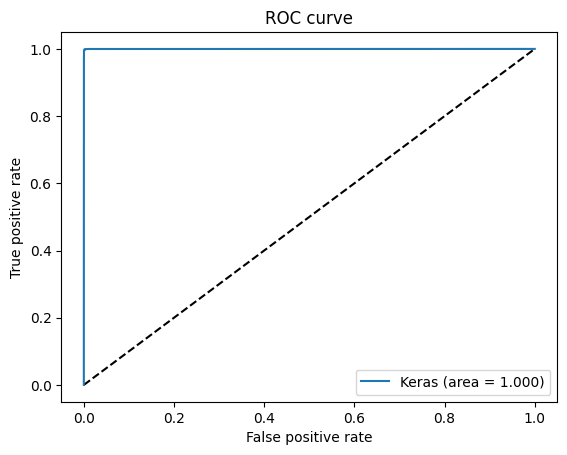

In [11]:
import matplotlib.pyplot as plt
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Sim 2

In [12]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.models import Sequential
from tensorflow import keras as keras
x_train, y_train = parse_fasta(read_fasta('./sim2/train.fasta'))
x_train = [rna_to_one_hot(i) for i in x_train]
x_train = np.array(x_train)
y_train = np.array(y_train)

x_validation, y_validation = parse_fasta(read_fasta('./sim2/validation.fasta'))
x_validation = [rna_to_one_hot(i) for i in x_validation]
x_validation = np.array(x_validation)
y_validation = np.array(y_validation)

x_test, y_test = parse_fasta(read_fasta('./sim2/test.fasta'))
x_test = [rna_to_one_hot(i) for i in x_test]
x_test = np.array(x_test)
y_test = np.array(y_test)


# Define the model
sequence_length = x_train.shape[1]
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=20, activation='relu',
          input_shape=(sequence_length, 4)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=64, activation='LeakyReLU'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, verbose=1,  
 validation_data=(x_validation, y_validation),batch_size=128, epochs=100,  
       callbacks=[EarlyStopping(patience=10, monitor="val_loss", 
 restore_best_weights=True), History()])  

# Evaluate the model
model.evaluate(x_test, y_test)


Epoch 1/100
157/157 [==============================] - 3s 17ms/step - loss: 0.7134 - accuracy: 0.4947 - val_loss: 0.6920 - val_accuracy: 0.5189
Epoch 2/100
157/157 [==============================] - 2s 14ms/step - loss: 0.6918 - accuracy: 0.5178 - val_loss: 0.6873 - val_accuracy: 0.5286
Epoch 3/100
157/157 [==============================] - 2s 14ms/step - loss: 0.6792 - accuracy: 0.5658 - val_loss: 0.6943 - val_accuracy: 0.5184
Epoch 4/100
157/157 [==============================] - 2s 14ms/step - loss: 0.6469 - accuracy: 0.6260 - val_loss: 0.6107 - val_accuracy: 0.6690
Epoch 5/100
157/157 [==============================] - 2s 13ms/step - loss: 0.5294 - accuracy: 0.7424 - val_loss: 0.4446 - val_accuracy: 0.8069
Epoch 6/100
157/157 [==============================] - 2s 14ms/step - loss: 0.4013 - accuracy: 0.8291 - val_loss: 0.3682 - val_accuracy: 0.8508
Epoch 7/100
157/157 [==============================] - 2s 13ms/step - loss: 0.3054 - accuracy: 0.8832 - val_loss: 0.3052 - val_accuracy:

[0.11395639926195145, 0.9682499766349792]

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

625/625 [==============================] - 2s 3ms/step


0.99407807

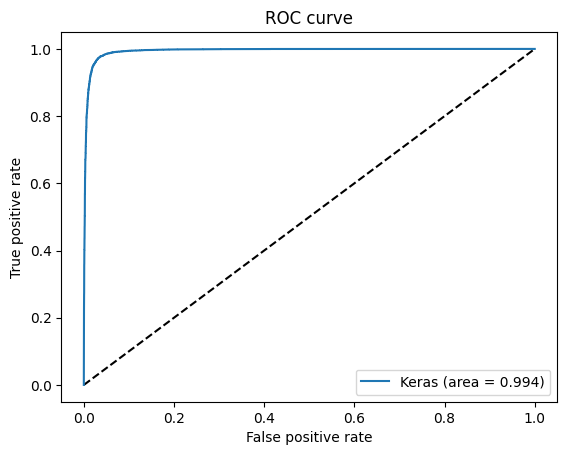

In [14]:
import matplotlib.pyplot as plt
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Sim 6

In [15]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.models import Sequential
from tensorflow import keras as keras
x_train, y_train = parse_fasta(read_fasta('./sim6/train.fasta'))
x_train = [rna_to_one_hot(i) for i in x_train]
x_train = np.array(x_train)
y_train = np.array(y_train)

x_validation, y_validation = parse_fasta(read_fasta('./sim6/validation.fasta'))
x_validation = [rna_to_one_hot(i) for i in x_validation]
x_validation = np.array(x_validation)
y_validation = np.array(y_validation)

x_test, y_test = parse_fasta(read_fasta('./sim6/test.fasta'))
x_test = [rna_to_one_hot(i) for i in x_test]
x_test = np.array(x_test)
y_test = np.array(y_test)


# Define the model
sequence_length = x_train.shape[1]
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=20, activation='relu',
          input_shape=(sequence_length, 4)))


model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=64, activation='LeakyReLU'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, verbose=1,  
 validation_data=(x_validation, y_validation),batch_size=128, epochs=100,  
       callbacks=[EarlyStopping(patience=10, monitor="val_loss", 
 restore_best_weights=True), History()])  

# Evaluate the model
model.evaluate(x_test, y_test)


Epoch 1/100
157/157 [==============================] - 4s 18ms/step - loss: 0.7002 - accuracy: 0.4925 - val_loss: 0.6895 - val_accuracy: 0.5715
Epoch 2/100
157/157 [==============================] - 2s 14ms/step - loss: 0.6499 - accuracy: 0.6197 - val_loss: 0.5898 - val_accuracy: 0.7046
Epoch 3/100
157/157 [==============================] - 2s 14ms/step - loss: 0.5475 - accuracy: 0.7293 - val_loss: 0.5034 - val_accuracy: 0.7703
Epoch 4/100
157/157 [==============================] - 2s 13ms/step - loss: 0.4624 - accuracy: 0.7942 - val_loss: 0.4352 - val_accuracy: 0.8112
Epoch 5/100
157/157 [==============================] - 2s 13ms/step - loss: 0.3996 - accuracy: 0.8281 - val_loss: 0.3921 - val_accuracy: 0.8285
Epoch 6/100
157/157 [==============================] - 2s 14ms/step - loss: 0.3484 - accuracy: 0.8526 - val_loss: 0.3496 - val_accuracy: 0.8454
Epoch 7/100
157/157 [==============================] - 2s 14ms/step - loss: 0.2937 - accuracy: 0.8819 - val_loss: 0.2963 - val_accuracy:

[0.011765053495764732, 0.9971500039100647]

In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

625/625 [==============================] - 2s 3ms/step


0.99983428

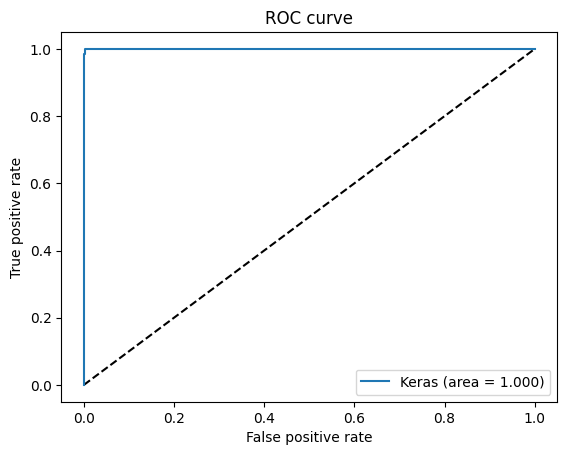

In [17]:
import matplotlib.pyplot as plt
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Sim 7

In [18]:
from keras import regularizers
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.models import Sequential
from tensorflow import keras as keras
x_train, y_train = parse_fasta(read_fasta('./sim7/train.fasta'))
x_train = [rna_to_one_hot(i) for i in x_train]
x_train = np.array(x_train)
y_train = np.array(y_train)

x_validation, y_validation = parse_fasta(read_fasta('./sim7/validation.fasta'))
x_validation = [rna_to_one_hot(i) for i in x_validation]
x_validation = np.array(x_validation)
y_validation = np.array(y_validation)

x_test, y_test = parse_fasta(read_fasta('./sim7/test.fasta'))
x_test = [rna_to_one_hot(i) for i in x_test]
x_test = np.array(x_test)
y_test = np.array(y_test)


# Define the model
sequence_length = x_train.shape[1]
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=20, activation='relu',
          input_shape=(sequence_length, 4)))

model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=512, activation='LeakyReLU'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=128, activation='LeakyReLU'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=32, activation='LeakyReLU'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, verbose=1,  
 validation_data=(x_validation, y_validation),batch_size=128, epochs=100,  
       callbacks=[EarlyStopping(patience=10, monitor="val_loss", 
 restore_best_weights=True), History()])  

# Evaluate the model
model.evaluate(x_test, y_test)


Epoch 1/100
157/157 [==============================] - 5s 27ms/step - loss: 0.7101 - accuracy: 0.4988 - val_loss: 0.6929 - val_accuracy: 0.5141
Epoch 2/100
157/157 [==============================] - 4s 23ms/step - loss: 0.6936 - accuracy: 0.5038 - val_loss: 0.6921 - val_accuracy: 0.5121
Epoch 3/100
157/157 [==============================] - 4s 23ms/step - loss: 0.6719 - accuracy: 0.5771 - val_loss: 0.5949 - val_accuracy: 0.6943
Epoch 4/100
157/157 [==============================] - 4s 24ms/step - loss: 0.5167 - accuracy: 0.7598 - val_loss: 0.4394 - val_accuracy: 0.8085
Epoch 5/100
157/157 [==============================] - 4s 23ms/step - loss: 0.4086 - accuracy: 0.8274 - val_loss: 0.3568 - val_accuracy: 0.8430
Epoch 6/100
157/157 [==============================] - 4s 23ms/step - loss: 0.3430 - accuracy: 0.8505 - val_loss: 0.2882 - val_accuracy: 0.8604
Epoch 7/100
157/157 [==============================] - 4s 24ms/step - loss: 0.2616 - accuracy: 0.8935 - val_loss: 0.2128 - val_accuracy:

[0.06528043746948242, 0.9779000282287598]

In [19]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

625/625 [==============================] - 3s 4ms/step


0.995998695

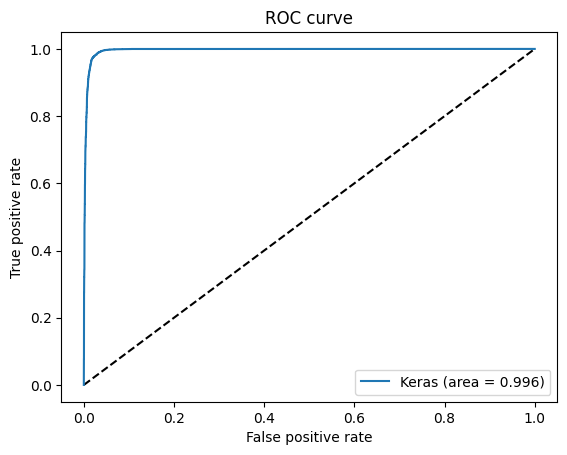

In [20]:
import matplotlib.pyplot as plt
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## MPRA

In [3]:
import numpy as np

def read_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()[1:]  # Skip the header row
    data = []
    for line in lines:
        row = line.strip().split('\t')
        x_norm = float(row[-2])
        y_norm = float(row[-1])
        data.append([x_norm, y_norm])
    return np.array(data)

# change fasta file into a list of sequences
# fasta reader


def read_fasta(file):
    with open(file, 'r') as f:
        lines = f.readlines()
    return lines

# fasta parser


def parse_fasta(lines):
    seq_list = []
    seq_name = [line[-2] for line in lines if line.startswith('>')]
    seq = ''
    for line, index in zip(lines, range(len(lines))):
        if index == len(lines) - 1:
            seq += line.strip()
            seq_list.append(seq)
        if line.startswith('>'):
            seq_list.append(seq)
            seq = ''
            continue
        else:
            seq += line.strip()
    for i in seq_list:
        if i == '':
            seq_list.remove(i)
    return seq_list, seq_name


In [4]:
x_train, _ = parse_fasta(read_fasta('./MPRA/Sequences_Train.fa'))
x_train = [rna_to_one_hot(i) for i in x_train]
x_train = np.array(x_train)
y_train = read_file('./MPRA/Sequences_activity_Train.txt')

x_validation, _ = parse_fasta(read_fasta('./MPRA/Sequences_Val.fa'))
x_validation = [rna_to_one_hot(i) for i in x_validation]
x_validation = np.array(x_validation)
y_validation = read_file('./MPRA/Sequences_activity_Val.txt')

x_test, _ = parse_fasta(read_fasta('./MPRA/Sequences_Test.fa'))
x_test = [rna_to_one_hot(i) for i in x_test]
x_test = np.array(x_test)
y_test = read_file('./MPRA/Sequences_activity_Test.txt')


In [5]:
from tensorflow import keras as keras
from keras import regularizers
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, History


# Define the model
sequence_length = x_train.shape[1]
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=15, activation='relu',
                 input_shape=(sequence_length, 4)))

model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units=512, activation='LeakyReLU'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=128, activation='LeakyReLU'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=32, activation='LeakyReLU'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=2, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error',  # changed loss function for regression
              metrics=['mse'])

# Train the model
model.fit(x_train, y_train, verbose=1,
          validation_data=(x_validation, y_validation), batch_size=256, epochs=20,
          callbacks=[EarlyStopping(patience=0, monitor="val_loss",
                                   restore_best_weights=True), History()])

# Evaluate the model
model.evaluate(x_test, y_test)


2023-04-09 11:04:32.710445: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-09 11:04:32.757313: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-09 11:04:32.757754: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-09 11:04:34.248717: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/20
1116/1116 [==============================] - 45s 39ms/step - loss: 2.3555 - mse: 2.3555 - val_loss: 2.0813 - val_mse: 2.0813
Epoch 2/20
1116/1116 [==============================] - 45s 40ms/step - loss: 2.0088 - mse: 2.0088 - val_loss: 1.8627 - val_mse: 1.8627
Epoch 3/20
1116/1116 [==============================] - 43s 39ms/step - loss: 1.8439 - mse: 1.8439 - val_loss: 1.7601 - val_mse: 1.7601
Epoch 4/20
1116/1116 [==============================] - 43s 39ms/step - loss: 1.7570 - mse: 1.7570 - val_loss: 1.6790 - val_mse: 1.6790
Epoch 5/20
1116/1116 [==============================] - 44s 40ms/step - loss: 1.7005 - mse: 1.7005 - val_loss: 1.6618 - val_mse: 1.6618
Epoch 6/20
1116/1116 [==============================] - 43s 39ms/step - loss: 1.6644 - mse: 1.6644 - val_loss: 1.6477 - val_mse: 1.6477
Epoch 7/20
1116/1116 [==============================] - 43s 38ms/step - loss: 1.6327 - mse: 1.6327 - val_loss: 1.6371 - val_mse: 1.6371
Epoch 8/20
1116/1116 [==========================

[1.5908445119857788, 1.5908445119857788]

In [7]:
y_pred = model.predict(x_test).ravel()
y_pred

3418/3418 [==============================] - 13s 4ms/step


array([-0.4869976 , -0.56775373,  1.6459574 , ..., -0.27309537,
        0.5779784 , -0.14990799], dtype=float32)

In [36]:
y_pred[0]

-0.49759614

In [34]:
y_test[0,1]

1.30334648450213

In [37]:
len(y_test)

109350

In [39]:
mse_dev = 0
for i in range(len(y_test)):
    mse_dev += (y_pred[2 * i] - y_test[i,0])**2
mse_dev = mse_dev/len(y_test)
mse_dev

1.733527790594978

In [40]:
mse_hk = 0
for i in range(len(y_test)):
    mse_hk += (y_pred[2 * i + 1] - y_test[i,1])**2
mse_hk = mse_hk/len(y_test)
mse_hk

1.5294519590423887

In [14]:
from sklearn.metrics import r2_score
print('r2 score: ', r2_score(y_test[:,0], y_pred[0::2]))
print('r2 score: ', r2_score(y_test[:,1], y_pred[1::2]))

r2 score:  -0.18529448538522963
r2 score:  0.3964346531190365


In [13]:
y_pred[0::2]

array([-0.4869976 ,  1.6459574 ,  1.5686178 , ...,  0.04771575,
        0.01975346,  0.5779784 ], dtype=float32)